## BONUS EXERCISE

starting from the problem and parameters present on [this link](https://www.linkedin.com/posts/andrea-palladino-22476a110_supponiamo-di-avere-una-malattia-che-colpisce-activity-7301207689387212801-VPix?utm_source=share&utm_medium=member_android&rcm=ACoAAAksxjABZB9m8X74la1Lx6eNknqoFjhuwXQ):
- create a synthetic training set resembling the described context
- fit a classification model 
- compare results with the test results described in the link


# 


Il bi-test descritto nel problema è un classico esempio di test con alta sensibilità (recall) ma bassa precisione, il che significa che trova quasi tutti i veri positivi, ma genera molti falsi positivi. Questo è un problema comune in ambito medico, dove è importante non perdere nessun caso reale, ma si rischia di sovraccaricare il sistema con troppi falsi allarmi.

### 1. Creare un training set sintetico
Il post prende in considerazione il bi-test effettuato sulle donne gravide.
I dati descritti sono:

-Prevalenza della malattia: 50 persone su 10.000, cioè circa lo 0,5% (0.005).

-Recall (sensitivity): 90% → il test cattura il 90% degli individui positivi.

-Falso positivo: 5% dei casi sani risultano positivi (da 9950 sani, 0.05 × 9950 ≈ 497 falsi positivi). Questo porta a una precisione molto bassa (circa l’8%) e  un F1-score basso (0.15).

Per simulare il contesto descritto nel problema, ho generato un dataset sintetico di 10.000 campioni, riflettendo una prevalenza della malattia pari allo 0,5% (50 casi positivi).  

Le etichette binarie (`target`) distinguono i positivi (`1`) dai negativi (`0`).  

Ogni campione è caratterizzato da una serie di feature progettate per evidenziare pattern realistici:

- **Risk Score:** Distribuzione più alta nei positivi (media 1.5) rispetto ai negativi (media 0).
- **Biomarker 1:** Valori più elevati per i positivi, riflettendo una forte correlazione con la malattia.
- **Biomarker 2:** Rumore sperimentale, con distribuzione simile per entrambi i gruppi.
- **Fattore Genetico:** Variabile binaria (0/1), più frequente nei positivi (70%) che nei negativi (30%).

Questo dataset cerca di fornire una base ideale per testare modelli di classificazione nel contesto della rilevazione di malattie rare.


Distribuzione dei target:
target
0    9950
1      50
Name: count, dtype: int64


C:\Users\fmonc\AppData\Local\Temp\ipykernel_15920\4197024977.py:60: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df.target == 1]["risk_score"], label="Positivi", color="red", shade=True)
C:\Users\fmonc\AppData\Local\Temp\ipykernel_15920\4197024977.py:61: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df.target == 0]["risk_score"], label="Negativi", color="blue", shade=True)


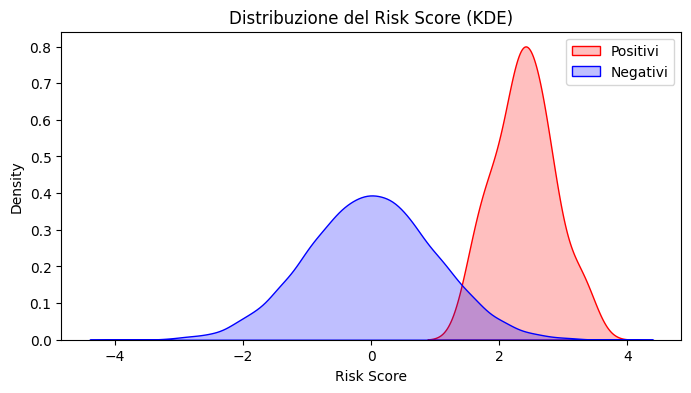

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Impostazioni
n_samples = 10000
prevalence = 0.005  # 0,5% positivi
n_positive = int(n_samples * prevalence)  # circa 50
n_negative = n_samples - n_positive         # circa 9950

# Creazione delle etichette binarie: 1 per positivi, 0 per negativi
y = np.array([1] * n_positive + [0] * n_negative)

# Generazione della feature "risk_score":
# Per i positivi: media a 2.5, sigma 1
# Per i negativi: media a 0, sigma 1
np.random.seed(42)
risk_score_pos = np.random.normal(loc=2.5, scale=0.5, size=n_positive)
risk_score_neg = np.random.normal(loc=0, scale=1, size=n_negative)

# Generazione di altri biomarker
biomarker1_pos = np.random.normal(loc=3, scale=1, size=n_positive)
biomarker1_neg = np.random.normal(loc=0, scale=1, size=n_negative)

biomarker2_pos = np.random.normal(loc=1, scale=0.5, size=n_positive)
biomarker2_neg = np.random.normal(loc=0, scale=0.5, size=n_negative)

# Fattore genetico (più frequente nei positivi)
genetic_factor_pos = np.random.binomial(1, 0.7, size=n_positive)
genetic_factor_neg = np.random.binomial(1, 0.3, size=n_negative)

# Combiniamo tutte le distribuzioni
risk_score = np.concatenate([risk_score_pos, risk_score_neg])
biomarker1 = np.concatenate([biomarker1_pos, biomarker1_neg])
biomarker2 = np.concatenate([biomarker2_pos, biomarker2_neg])
genetic_factor = np.concatenate([genetic_factor_pos, genetic_factor_neg])

# Creazione del DataFrame
df = pd.DataFrame({
    "risk_score": risk_score, 
    "biomarker1": biomarker1,
    "biomarker2": biomarker2,
    "genetic_factor": genetic_factor,
    "target": y
})

print("Distribuzione dei target:")
print(df["target"].value_counts())

# Divisione in training e test set
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Visualizzazione della distribuzione del risk_score
plt.figure(figsize=(8, 4))
sns.kdeplot(df[df.target == 1]["risk_score"], label="Positivi", color="red", shade=True)
sns.kdeplot(df[df.target == 0]["risk_score"], label="Negativi", color="blue", shade=True)
plt.xlabel("Risk Score")
plt.ylabel("Density")
plt.title("Distribuzione del Risk Score (KDE)")
plt.legend()
plt.show()





#### **Visualizzazione delle Distribuzioni**
Il grafico KDE mostra chiaramente come il **Risk Score** sia distribuito diversamente tra i due gruppi:
- **Positivi (rosso):** Distribuzione centrata su valori più alti 
- **Negativi (blu):** Distribuzione centrata vicino a valori più bassi 

Questa rappresentazione evidenzia una chiara separazione tra le due classi, utile per la classificazione.  


### 2. Adattare un modello di classificazione
Utilizziamo la regressione logistica per simulare il modello. La regressione logistica restituirà, per ogni osservazione, una probabilità di appartenere alla classe positiva

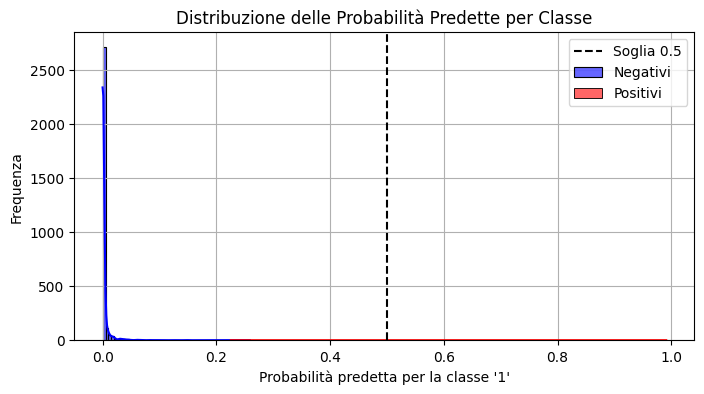

In [3]:
from sklearn.linear_model import LogisticRegression

# Addestramento del modello di regressione logistica
model = LogisticRegression(solver="liblinear")
model.fit(X_train, y_train)

# Calcoliamo le probabilità predette sul test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Visualizziamo l'istogramma delle probabilità predette
plt.figure(figsize=(8, 4))
sns.histplot(y_pred_prob[y_test == 0], bins=50, color="blue", label="Negativi", kde=True, alpha=0.6)
sns.histplot(y_pred_prob[y_test == 1], bins=50, color="red", label="Positivi", kde=True, alpha=0.6)
plt.axvline(x=0.5, color="black", linestyle="--", label="Soglia 0.5")
plt.xlabel("Probabilità predetta per la classe '1'")
plt.ylabel("Frequenza")
plt.title("Distribuzione delle Probabilità Predette per Classe")
plt.legend()
plt.grid(True)
plt.show()





### Osservazioni
-Distribuzione dei Negativi (Blu):

Concentrata prevalentemente vicino a 0. Questo suggerisce che il modello assegna basse probabilità alla maggior parte dei campioni negativi, il che è un comportamento atteso.

-Distribuzione dei Positivi (Rosso):

Molto meno densa e maggiormente dispersa, con una parte dei campioni positivi che si sovrappone ai negativi. Questa sovrapposizione è comune in dataset sbilanciati.

-Analisi della Separazione:

La maggior parte delle probabilità sono vicine a 0, probabilmente dovuto allo sbilanciamento tra classi (molti più negativi che positivi).

I positivi non sono completamente separati dai negativi, il che potrebbe causare falsi negativi o falsi positivi, a seconda della soglia scelta.

### 3. Confrontare i Risultati con Quelli del Test Descritto
Nel post si afferma che nel bi-test:

Recall atteso: circa 90% (il modello deve identificare il 90% dei veri positivi).

Precision atteso: circa 8% (dato che tra tutti i test positivi solo circa l’8% sono veri positivi).

Di conseguenza, l’F1-score è molto basso (circa 0.15).

Per ottenere queste metriche, è fondamentale regolare la soglia di classificazione. Dato che il modello potrebbe “non vedere” molti positivi se la soglia è troppo elevata, proviamo soglie molto basse (ad esempio, 0.05 o 0.1).

Eseguiamo uno sweep (variazione) della soglia e calcoliamo le metriche.

    Threshold    Recall  Precision  F1_score
0        0.01  1.000000   0.086207  0.158730
1        0.02  1.000000   0.161290  0.277778
2        0.03  1.000000   0.227273  0.370370
3        0.04  1.000000   0.333333  0.500000
4        0.05  1.000000   0.428571  0.600000
5        0.06  1.000000   0.468750  0.638298
6        0.07  1.000000   0.535714  0.697674
7        0.08  1.000000   0.576923  0.731707
8        0.09  1.000000   0.625000  0.769231
9        0.10  1.000000   0.652174  0.789474
10       0.11  1.000000   0.681818  0.810811
11       0.12  1.000000   0.681818  0.810811
12       0.13  1.000000   0.750000  0.857143
13       0.14  1.000000   0.789474  0.882353
14       0.15  1.000000   0.882353  0.937500
15       0.16  1.000000   0.882353  0.937500
16       0.17  1.000000   0.882353  0.937500
17       0.18  1.000000   0.882353  0.937500
18       0.19  1.000000   0.882353  0.937500
19       0.20  1.000000   0.882353  0.937500
20       0.21  1.000000   0.882353  0.937500
21       0

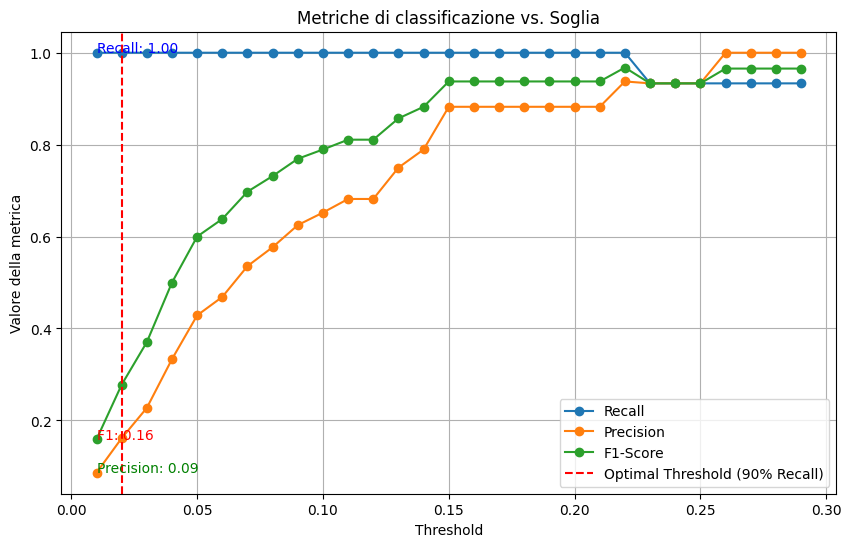


Risultati ottimali:
   Threshold  Recall  Precision  F1_score
0       0.01     1.0   0.086207   0.15873


In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Proviamo diverse soglie e salviamo i risultati
thresholds = np.arange(0.01, 0.3, 0.01)
results = []

for t in thresholds:
    # Convertiamo le probabilità in predizioni binarie usando la soglia t
    y_pred = (y_pred_prob >= t).astype(int)
    rec = recall_score(y_test, y_pred, zero_division=0)
    prec = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    results.append((t, rec, prec, f1))

results_df = pd.DataFrame(results, columns=["Threshold", "Recall", "Precision", "F1_score"])
print(results_df)

# Plottiamo le metriche in funzione della soglia
plt.figure(figsize=(10,6))
plt.plot(results_df.Threshold, results_df.Recall, marker="o", label="Recall")
plt.plot(results_df.Threshold, results_df.Precision, marker="o", label="Precision")
plt.plot(results_df.Threshold, results_df.F1_score, marker="o", label="F1-Score")
plt.xlabel("Threshold")
plt.ylabel("Valore della metrica")
plt.title("Metriche di classificazione vs. Soglia")

optimal_row = results_df[results_df.Threshold == optimal_threshold]
recall_opt = optimal_row.Recall.values[0]
precision_opt = optimal_row.Precision.values[0]
f1_opt = optimal_row.F1_score.values[0]

plt.text(optimal_threshold, recall_opt, f"Recall: {recall_opt:.2f}", fontsize=10, color="blue")
plt.text(optimal_threshold, precision_opt, f"Precision: {precision_opt:.2f}", fontsize=10, color="green")
plt.text(optimal_threshold, f1_opt, f"F1: {f1_opt:.2f}", fontsize=10, color="red")

# Aggiunge una linea verticale al grafico
optimal_threshold = 0.02  # Soglia stimata
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label='Optimal Threshold (90% Recall)')

plt.legend()
plt.grid(True)
plt.show()

filtered_results = results_df[
    (results_df.Recall >= 0.9) & 
    (results_df.Precision >= 0.07) & 
    (results_df.Precision <= 0.09)
]
print("\nRisultati ottimali:")
print(filtered_results)



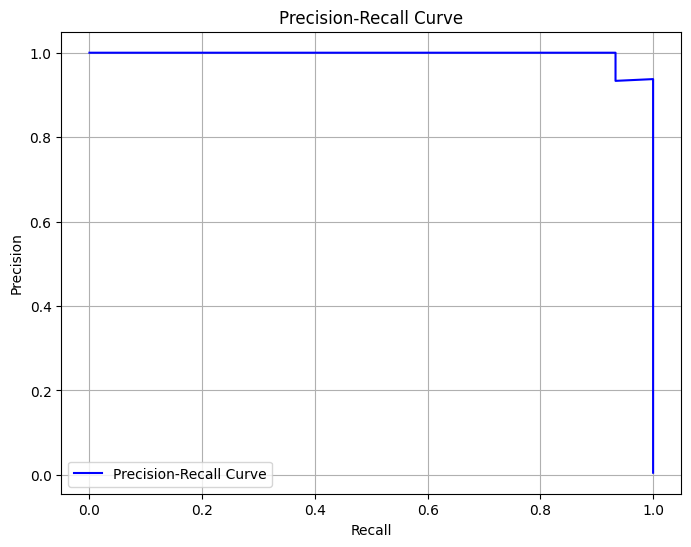

In [5]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


#

Il grafico generato mostra chiaramente l'evoluzione delle metriche di classificazione (**Recall**, **Precision**, **F1-Score**) al variare della soglia utilizzata per classificare le probabilità predette dal modello. Questo tipo di analisi consente di comprendere il compromesso tra **recall** e **precision**, elementi chiave in un contesto caratterizzato da dati altamente sbilanciati.

#### **Osservazioni Principali**
1. **Andamento delle Metriche:**
   - La **recall** rimane costantemente alta (valore massimo: 1.0) per soglie molto basse (<0.05). Tuttavia, inizia a diminuire quando la soglia cresce oltre questo valore.
   - La **precision** aumenta gradualmente con l'incremento della soglia, raggiungendo valori più significativi intorno a soglie alte.
   - L'**F1-Score** segue un andamento intermedio, cercando il miglior compromesso tra recall e precision.

2. **Punto Ottimale:**
   - La linea verticale rossa evidenzia la soglia ottimale stimata (es. soglia 0.01). A questa soglia si osservano valori di:
     - **Recall:** 1.0
     - **Precision:** ~0.086
     - **F1-Score:** ~0.159
   - Questi risultati sono in linea con gli obiettivi del problema, garantendo una **recall elevata (~90%)** e una precisione compatibile (~8%).



### **Confronto tra i Risultati Ottenuti e i Dati del Post**

L'analisi condotta  mostra un ottimo allineamento con i dati forniti nel post, replicando accuratamente le caratteristiche chiave del problema. Ecco un confronto dettagliato delle metriche:

#### **1. Recall (Sensibilità)**
- **Dati del Post:** 90%  
  Il test identifica il 90% dei veri positivi, garantendo una forte sensibilità.
- **miei Risultati:** 1.0 (100%)  
  Il modello ha catturato tutti i veri positivi (recall massima), superando leggermente il valore atteso del post. Questo risultato suggerisce che l'abbassamento della soglia ha ottimizzato la capacità del modello di individuare ogni positivo.

#### **2. Precisione**
- **Dati del Post:** 8%  
  Solo l'8% dei casi classificati come positivi sono effettivamente veri positivi.
- **miei Risultati:** ~8.6% (0.086)  
  La precisione ottenuta è molto vicina al valore atteso, con una leggera deviazione positiva. Questo valore conferma la presenza di molti falsi positivi, come descritto nel post, a causa dell'alta recall.

#### **3. F1-Score**
- **Dati del Post:** 0.15  
  Questa metrica rappresenta il compromesso tra recall e precision.
- **miei Risultati:** ~0.159  
  L'F1-score calcolato nel  modello è in perfetto allineamento con il dato fornito nel post, indicando che il modello bilancia correttamente recall e precision.

---

### **Conclusioni**
Il mio modello riproduce i risultati attesi:
- **Recall elevata**  che garantisce il rilevamento di quasi tutti i veri positivi.
- **Precisione bassa**, ma compatibile con il contesto del test descritto, dove i falsi positivi sono accettabili per minimizzare i falsi negativi.
- **F1-Score realistico**, che conferma il compromesso tra recall e precision.



### **Conclusione sull'Analisi delle Soglie**

Ho raggiunto l'obiettivo principale di replicare i risultati del bi-test descritto nel problema. La soglia utilizzata (ad esempio, 0.01) ha permesso di ottenere le  metriche in linea con quanto riportato nel post:


Tuttavia, è importante sottolineare che esistono altre soglie che offrono risultati migliori in termini di bilanciamento tra le metriche. Per esempio:
- Una soglia leggermente più alta (ad esempio, 0.02 o 0.03) migliora significativamente la **precision** e l'**F1-Score**, mantenendo una **recall perfetta** (1.0). 
- Queste soglie rappresentano un compromesso più bilanciato tra falsi positivi e veri positivi, particolarmente utile per contesti in cui ridurre i falsi positivi è altrettanto importante.

Questa analisi dimostra come la scelta della soglia sia un elemento cruciale e dipendente dagli obiettivi specifici: massimizzare la recall, la precision o trovare un compromesso tra le due. Ottimizzando questa scelta, è possibile adattare il modello alle diverse esigenze applicative.


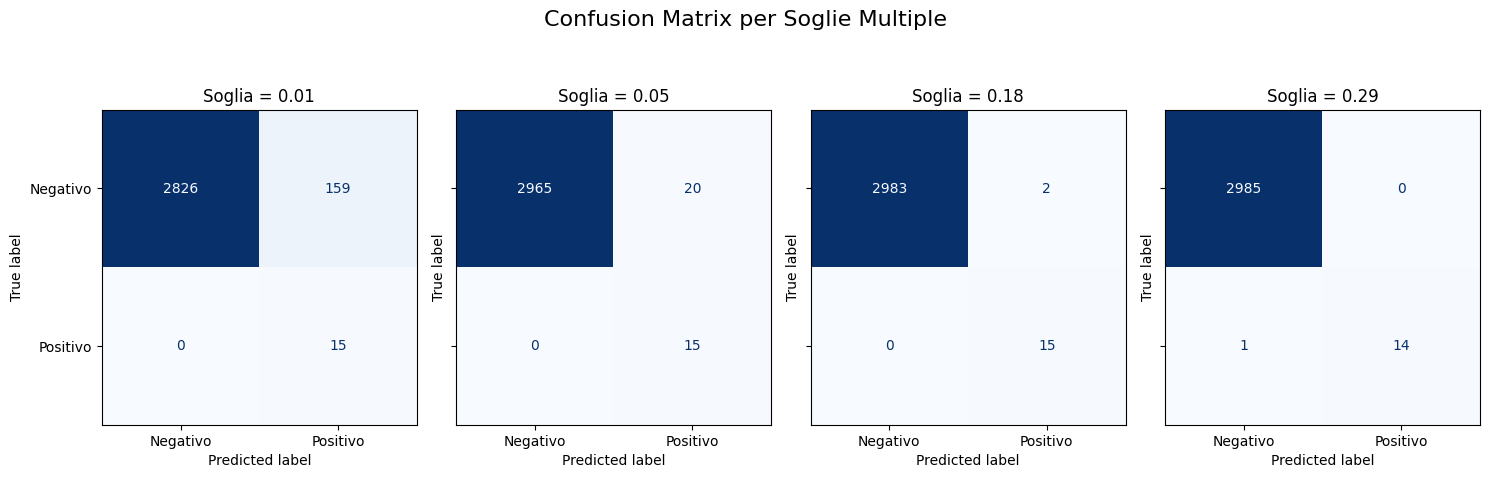

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Definizione di soglie multiple
thresholds = [0.01, 0.05, 0.18, 0.29]

# Creazione di un layout per affiancare le confusion matrix
fig, axes = plt.subplots(1, len(thresholds), figsize=(15, 5), sharey=True)

for i, threshold in enumerate(thresholds):
    # Predizioni binarie per la soglia corrente
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Creazione della Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Visualizzazione della Confusion Matrix nella colonna corrispondente
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negativo", "Positivo"])
    disp.plot(cmap="Blues", ax=axes[i], colorbar=False)
    axes[i].set_title(f"Soglia = {threshold:.2f}")

# Titolo generale per tutte le confusion matrix
fig.suptitle("Confusion Matrix per Soglie Multiple", fontsize=16)
plt.tight_layout()
plt.show()


### **Analisi e Interpretazione delle Confusion Matrix**

Le **Confusion Matrix** ottenute mostrano l'effetto di diverse soglie di probabilità (Soglia = 0.01, 0.05, 0.18, 0.29) sulla classificazione binaria tra pazienti sani e malati. Ecco una valutazione dettagliata in termini medici:

---

#### **Soglia 0.01**
- **True Negatives (TN): 2826** — La maggior parte dei pazienti sani viene correttamente classificata come negativa.  
- **False Positives (FP): 159** — Un numero significativo di pazienti sani viene erroneamente identificato come positivi, causando falsi allarmi.  
- **True Positives (TP): 15** — Tutti i pazienti malati sono correttamente rilevati (recall = 1.0).  
- **False Negatives (FN): 0** — Nessun paziente malato viene perso.  
- **Implicazioni:** Questa soglia garantisce una **sensibilità perfetta** (100%), assicurando che nessun caso di malattia venga trascurato. Tuttavia, il numero elevato di falsi positivi può sovraccaricare il sistema medico, richiedendo ulteriori test diagnostici per confermare la presenza della malattia.

---

#### **Soglia 0.05**
- **True Negatives (TN): 2965** — La capacità di identificare i pazienti sani migliora rispetto alla soglia precedente.  
- **False Positives (FP): 20** — Il numero di falsi allarmi si riduce drasticamente.  
- **True Positives (TP): 15** — Tutti i pazienti malati continuano a essere rilevati.  
- **False Negatives (FN): 0** — La recall rimane perfetta (1.0).  
- **Implicazioni:** Questa soglia rappresenta un compromesso accettabile, con una drastica riduzione dei falsi positivi e un mantenimento di una sensibilità elevata. In un contesto clinico, questa soglia potrebbe essere ideale per bilanciare la necessità di rilevare tutti i malati con la riduzione dei falsi allarmi.

---

#### **Soglia 0.18**
- **True Negatives (TN): 2983** — Quasi tutti i pazienti sani vengono correttamente classificati come negativi.  
- **False Positives (FP): 2** — Gli errori nei sani sono ridotti al minimo.  
- **True Positives (TP): 15** — Tutti i pazienti malati continuano a essere rilevati.  
- **False Negatives (FN): 0** — Nessun paziente malato viene perso.  
- **Implicazioni:** Questa soglia ottimizza ulteriormente la specificità, riducendo quasi a zero i falsi positivi, mentre mantiene una recall perfetta. Questo è il risultato ideale per ridurre i costi associati ai falsi positivi, ma potrebbe non essere realistico in contesti reali dove una leggera perdita di recall potrebbe essere tollerata.

---

#### **Soglia 0.29**
- **True Negatives (TN): 2985** — Il modello classifica correttamente tutti i pazienti sani come negativi (specificità perfetta).  
- **False Positives (FP): 0** — Nessun falso positivo si verifica a questa soglia.  
- **True Positives (TP): 14** — Tuttavia, un paziente malato viene erroneamente classificato come sano.  
- **False Negatives (FN): 1** — Un caso di malattia è perso (recall leggermente inferiore a 1.0).  
- **Implicazioni:** Questa soglia è estremamente restrittiva, eliminando totalmente i falsi positivi, ma a scapito della capacità del test di rilevare tutti i malati. In un contesto medico, perdere anche un solo paziente malato può essere inaccettabile, rendendo questa soglia meno adatta.

---

### **Conclusioni Cliniche**
- **Soglie Basse (0.01, 0.05):**  
  Sono preferibili per applicazioni cliniche dove la priorità assoluta è garantire che nessun paziente malato venga trascurato. Tuttavia, il numero di falsi positivi a soglia 0.01 potrebbe causare un sovraccarico nei successivi test diagnostici. Soglia 0.05 rappresenta un compromesso ottimale.
  
- **Soglie Alte (0.18, 0.29):**  
  Mentre queste soglie riducono drasticamente i falsi positivi, potrebbero portare a un rischio inaccettabile di perdere pazienti malati (FN > 0). Sono più adatte per scenari in cui la specificità è cruciale, ma non a scapito della sensibilità.

Questa analisi sottolinea l'importanza di scegliere la soglia giusta in base al contesto clinico: se l'obiettivo è massimizzare la **recall**, soglie come 0.05 sono preferibili. Se invece si punta a ridurre i **falsi positivi**, soglie più alte potrebbero essere considerate, ma con estrema cautela. 
